In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats, integrate, optimize, special
import random
from scipy import interpolate
import networkx as nx

In [3]:
# 関数の定義
def model_beta(x, alpha, beta):
    Np = 618
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [4]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [5]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [6]:
# left
node_left, edge_left, timestamp_left = return_nm(df_left)

In [7]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
df_left.head()

,node,edge
0,447,2293
1,468,2606
2,485,3528
3,437,2288
4,465,2889


In [8]:
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
df_left.head()

,node,edge
60,106,190
289,136,221
288,173,312
273,215,368
290,217,494


In [9]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta, xdata=df_left["edge"], ydata=df_left["node"])

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  0.7713341086699671
beta:  27.396756800724045


In [11]:
Np = max(df_left["node"])
alpha = params[0]
beta = params[1]

kappa = []
for i in range(len(df_left["node"])):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * df_left["edge"][i]) / (Np**2 - Np)) )

In [12]:
Nfit = []
for i in range(len(df_left["edge"])):
    Nfit.append(model_beta([df_left["edge"][i]], alpha, beta))

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_13153/276521255.py:4: RuntimeWarning: overflow encountered in scalar power
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)


In [13]:
Mfit = []
for i in range(len(df_left["edge"])):
    Mfit.append((kappa[i]*Np*(Np-1))/8)

/Users/yiadka/dev/master_ver2/venv/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step


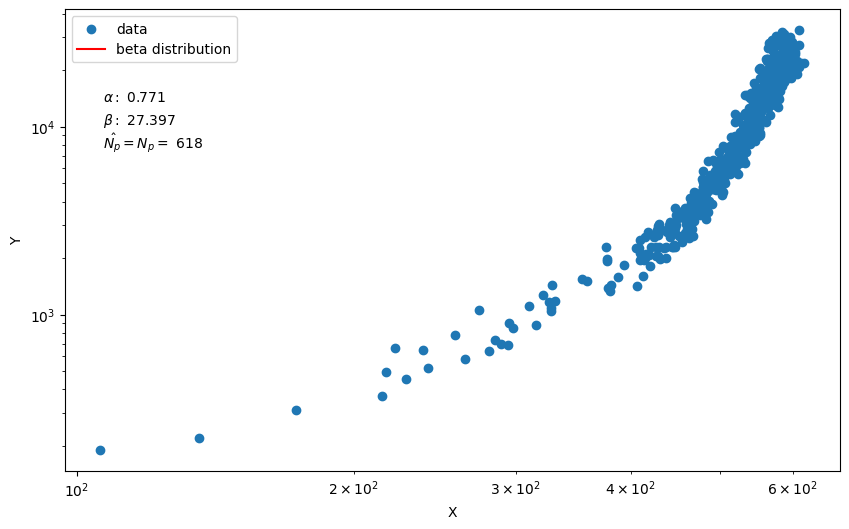

In [14]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nfit, Mfit,
                                   kind="linear")
x_new = np.linspace(min(Nfit), max(Nfit), 1000)
y_new = spline_func(x_new)

# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(node_left, edge_left, label='data')
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
plt.text(0.05, 0.80, r'$\alpha:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.75, r'$\beta:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=N_{p}=$ ' + str(Np), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [11]:
# 正規化する
node_norm = node_left - min(node_left) + 2
edge_norm = edge_left - min(edge_left) + 1

In [13]:
# 関数の定義
def model_beta_norm(x, alpha, beta):
    Np = 514
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [14]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm, xdata=edge_norm, ydata=node_norm)

print("alpha: ", params[0])
print("beta: ", params[1])


+------------------+
| Estimating       |
+------------------+
alpha:  0.46699587157956646
beta:  0.6590156747245888


In [15]:
kappa = []
for i in range(len(edge_norm)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * edge_norm[i]) / (Np**2 - Np)) )

In [16]:
Np = max(node_norm)
alpha = params[0]
beta = params[1]

Nnorm_fit = []
for i in range(len(edge_norm)):
    Nnorm_fit.append(model_beta([edge_norm[i]], alpha, beta))

Mnorm_fit = []
for i in range(len(kappa)):
    Mnorm_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

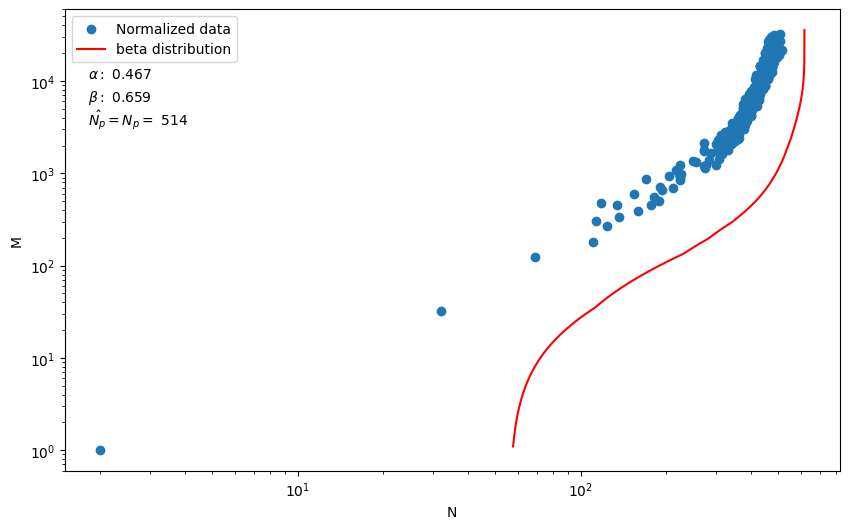

In [17]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nnorm_fit, Mnorm_fit,
                                   kind="linear")
x_new = np.linspace(min(Nnorm_fit), max(Nnorm_fit), 1000)
y_new = spline_func(x_new)

plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
# plt.scatter(Nnorm_fit, Mnorm_fit, label="fit", c="red") 
plt.scatter(node_norm, edge_norm, label="Normalized data")
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
# node_normとMnorm_fitの間を補間する

plt.text(0.03, 0.85, r'$\alpha:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.80, r'$\beta:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.75, r'$\hat{N_{p}}=N_{p}=$ ' + str(Np), transform=plt.gca().transAxes)

plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


## 正規化プロセス2
$$
N_{mod} = N - N_{min} / <k>
$$

$$
M_{mod} = M - M_{min} / <k>
$$

In [18]:
# edgeを平均次数で割る
# ネットワークの平均次数
k = sum(edge_left) / sum(node_left)
k = round(k, 3)
print("k: ", k)

k:  23.169


In [19]:
# edge_left / k
Nnorm2 = []
for i in range(len(node_left)):
    Nnorm2.append((node_left[i] - min(node_left)) / k)

In [20]:
Mnorm2 = []
for i in range(len(edge_left)):
    Mnorm2.append((edge_left[i] - min(edge_left))/ k)

In [21]:
max(Nnorm2)

22.098493676895853

In [22]:
# 関数の定義
def model_beta_norm2(x, alpha, beta):
    Np = 22.1
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [23]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm2, xdata=Mnorm2, ydata=Nnorm2)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  0.8416496265669934
beta:  1.4267008156230372


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_12380/1892473104.py:4: RuntimeWarning: overflow encountered in power
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_12380/1892473104.py:4: RuntimeWarning: invalid value encountered in power
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)


In [25]:
kappa = []
for i in range(len(Mnorm2)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * Mnorm2[i]) / (Np**2 - Np)) )

In [26]:
Np = max(Nnorm2)
alpha = params[0]
beta = params[1]

Nnorm2_fit = []
for i in range(len(Mnorm2)):
    Nnorm2_fit.append(model_beta([Mnorm2[i]], alpha, beta))

Mnorm2_fit = []
for i in range(len(kappa)):
    Mnorm2_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

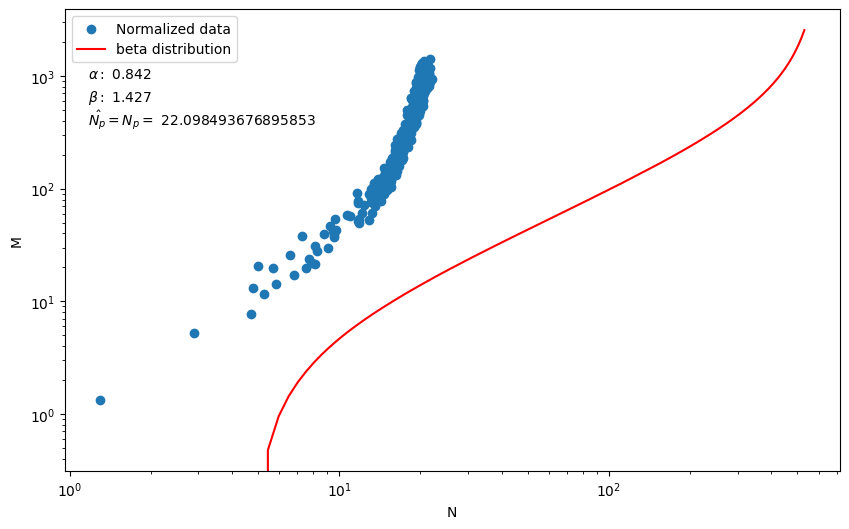

In [27]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nnorm2_fit, Mnorm2_fit,
                                   kind="linear")
x_new = np.linspace(min(Nnorm2_fit), max(Nnorm2_fit), 1000)
y_new = spline_func(x_new)

plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
# plt.scatter(Nnorm_fit, Mnorm_fit, label="fit", c="red") 
plt.scatter(Nnorm2, Mnorm2, label="Normalized data")
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
# node_normとMnorm_fitの間を補間する

plt.text(0.03, 0.85, r'$\alpha:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.80, r'$\beta:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.75, r'$\hat{N_{p}}=N_{p}=$ ' + str(Np), transform=plt.gca().transAxes)

plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


## 正規化プロセス3
$$
N_{norm} = \frac{N_{i} - N_{min}}{k_{i}}
$$

$$
M_{norm} = \frac{M_{i} - M{min}}{k_{i}}
$$

## 正規化プロセス4

In [37]:
# Nの平均を求める
N_mu = sum(node_left) / len(node_left)
N_mu = round(N_mu, 3)

# Mの平均を求める
M_mu = sum(edge_left) / len(edge_left)
M_mu = round(M_mu, 3)

In [38]:
# Nの分散を求める
N_var = sum((node_left - N_mu)**2) / len(node_left)
N_var = round(N_var, 3)

# Mの分散を求める
M_var = sum((edge_left - M_mu)**2) / len(edge_left)
M_var = round(M_var, 3)

In [39]:
# 正規化
Nnorm = []
for i in range(len(node_left)):
    Nnorm.append((node_left[i] - N_mu) / N_var)

Mnorm = []
for i in range(len(edge_left)):
    Mnorm.append((edge_left[i] - M_mu) / M_var)

In [40]:
max(Nnorm)

0.017119158721030484

In [41]:
# 関数の定義
def model_beta_norm4(x, alpha, beta):
    Np = 0.02
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [42]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm4, xdata=Mnorm, ydata=Nnorm)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  0.8098401375381209
beta:  0.7896396140529369


In [43]:
kappa = []
for i in range(len(Mnorm)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * Mnorm[i]) / (Np**2 - Np)) )

In [47]:
Np = max(Nnorm)
alpha = params[0]
beta = params[1]

Nnorm_fit = []
for i in range(len(Mnorm2)):
    Nnorm_fit.append(model_beta([Mnorm[i]], alpha, beta))

Mnorm_fit = []
for i in range(len(kappa)):
    Mnorm_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

In [48]:
print(len(Nnorm_fit))
print(len(Mnorm_fit))

608
608


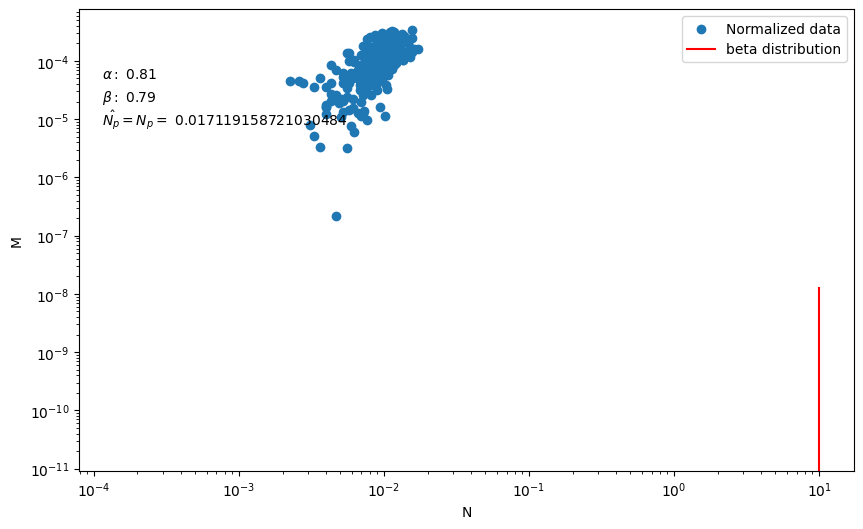

In [49]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nnorm_fit, Mnorm_fit,
                                   kind="linear")
x_new = np.linspace(min(Nnorm_fit), max(Nnorm_fit), 1000)
y_new = spline_func(x_new)

plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
# plt.scatter(Nnorm_fit, Mnorm_fit, label="fit", c="red") 
plt.scatter(Nnorm, Mnorm, label="Normalized data")
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
# node_normとMnorm_fitの間を補間する

plt.text(0.03, 0.85, r'$\alpha:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.80, r'$\beta:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
plt.text(0.03, 0.75, r'$\hat{N_{p}}=N_{p}=$ ' + str(Np), transform=plt.gca().transAxes)

plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


## 右側のデータを分析する

In [175]:
# Redefine
node_right, edge_right, timestamp_right = return_nm(df_right)

In [176]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params_right, _ = optimize.curve_fit(model_beta, xdata=edge_right, ydata=node_right)

print("alpha: ", params_right[0])
print("beta: ", params_right[1])

+------------------+
| Estimating       |
+------------------+
alpha:  1.3852481613913514
beta:  0.2674717906290024


In [177]:
alpha_right = params_right[0]
beta_right = params_right[1]

In [178]:
Np = max(node_right)

kappa = []
for i in range(len(edge_right)):
    kappa.append( (((alpha_right + beta_right)/alpha_right)**2) * ((2 * edge_right[i]) / (Np**2 - Np)) )

In [179]:
Nfit = []
for i in range(len(edge_right)):
    Nfit.append(model_beta([edge_right[i]], alpha_right, beta_right))

In [180]:
Mfit = []
for i in range(len(edge_right)):
    Mfit.append((kappa[i]*Np*(Np-1))/8)

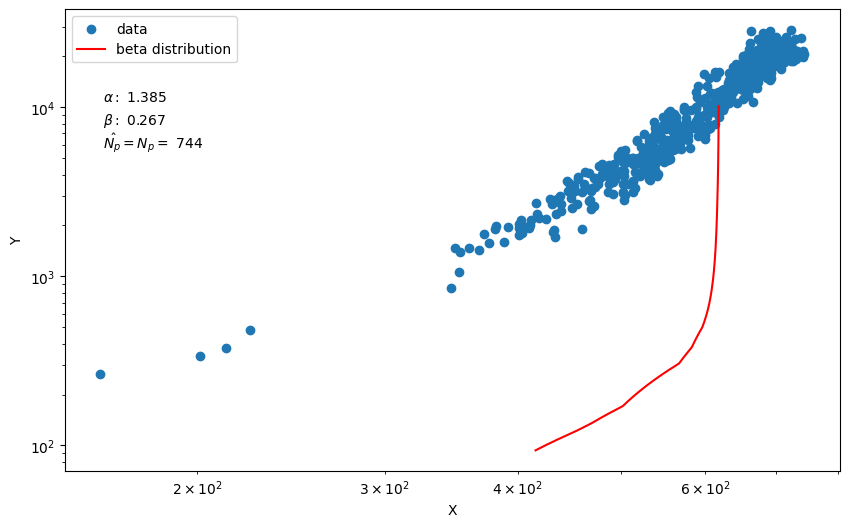

In [181]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nfit, Mfit,
                                   kind="linear")
x_new = np.linspace(min(Nfit), max(Nfit), 1000)
y_new = spline_func(x_new)

# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(node_right, edge_right, label='data')
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
plt.text(0.05, 0.80, r'$\alpha:$ ' + str(round(alpha_right, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.75, r'$\beta:$ ' + str(round(beta_right, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=N_{p}=$ ' + str(Np), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

## ベータ分布

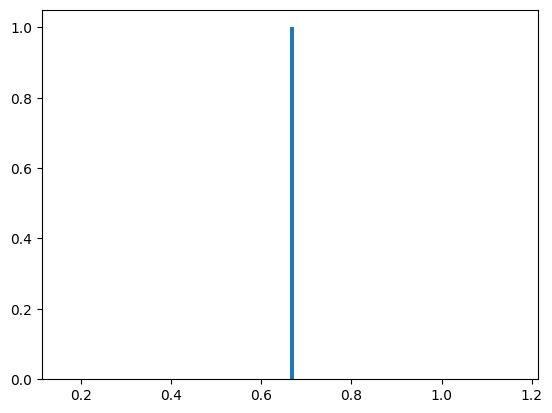

In [189]:
# rvs from beta distribution
alpha = 1.0
beta = 0.5
rvs = stats.beta.rvs(alpha, beta, size=1)
plt.hist(rvs, bins=100)
plt.show()
